In [51]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd.functional import jacobian
import tqdm
from tqdm import notebook
import random
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
import matplotlib.pyplot as plt

In [52]:
dev ='cuda'

In [53]:
torch.set_default_dtype(torch.float64)
torch.set_default_device(dev)

In [54]:
def G(gs):
    '''
    :param gs: a list of tensor functions
    :return: a function sending a tensor to the stacked matrix of the functions of that tensor
    '''
    def G_gs(tensor):
        x = torch.squeeze(tensor)
        # print("Function input: ",tensor) # checking the input for debugging
        # print("Function output:" , torch.stack([g(tensor) for g in gs],0))
        return torch.stack([g(x) for g in gs], 0)

    return G_gs

def J(gs, x):
    '''Returns the Jacobian evaluated at x for a list gs of constraint functions'''
    return jacobian(G(gs), torch.squeeze(x), create_graph = True, vectorize=True)

In [55]:
bones2 = [
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (11, 12),
    (12, 13),
    (13, 14),
    (15, 16),
    (16, 17),
    (17, 18),
]

In [56]:
def cotangent_projection(gs):
    def proj(x):
        G = J(gs,x)
        number = torch.inverse(G @ G.T)
        matrix = G.T @ G
        M = torch.eye(3)
        L= torch.eye(3) - G.T @ G *number
        return L
    return proj

In [57]:
class ScoreNet(nn.Module):
  """A time-dependent score-based model."""


  def __init__(self, embed_dim):
    super().__init__()
    self.lin1 = nn.Linear(3,75)
    self.lin2 = nn.Linear(75, 75)
    self.lin3 = nn.Linear(75, 75)
    self.lin4 = nn.Linear(75, 3)
    #self.lin5 = nn.Linear(57,57)
    self.act = torch.nn.Tanh()
    # Initializing the weights with the Xavier initialization method
    torch.nn.init.xavier_uniform_(self.lin1.weight)
    torch.nn.init.xavier_uniform_(self.lin2.weight)
    torch.nn.init.xavier_uniform_(self.lin3.weight)
    torch.nn.init.xavier_uniform_(self.lin4.weight)

  #@torch.compile(mode="default")
  def forward(self,x,L):

      h = self.lin1(x)
      h = self.act(self.lin2(h))
      h = self.act(self.lin3(h))
      h = self.lin4(h)
      #h = self.act(self.lin5(h))

      # projection

      p = torch.unsqueeze(L@ torch.squeeze(h),0)
      h = p

      # NOT normalizing the output
      #h = h/ t[:,None]

      # setting the force on the fixed point to zero
      return torch.squeeze(h)

In [58]:
score_model = ScoreNet(58)
# ckpt = torch.load('ckpt_moser_sphere24.pth')
# score_model.load_state_dict(ckpt)


In [59]:
from torch.utils.data import TensorDataset, DataLoader

In [60]:
from torch.optim import Adam

In [61]:
import warnings
warnings.filterwarnings("ignore")


In [62]:
#ckpt = torch.load('ckpt_moser_sphere3.pth')
score_model.train()
#score_model.load_state_dict(ckpt)

ScoreNet(
  (lin1): Linear(in_features=3, out_features=75, bias=True)
  (lin2): Linear(in_features=75, out_features=75, bias=True)
  (lin3): Linear(in_features=75, out_features=75, bias=True)
  (lin4): Linear(in_features=75, out_features=3, bias=True)
  (act): Tanh()
)

In [63]:
#torch._dynamo.config.verbose=True

In [64]:
#torch._dynamo.config.suppress_errors = True

# Sampling from the reverse SDE

In [65]:
pos = np.load('positions_gamma_7.npy',allow_pickle=True)[0::50]

In [66]:
np.random.shuffle(pos)

In [67]:
pos_list = [p for p in pos]
pos_tensor = torch.stack(pos_list)

In [68]:
len(pos_tensor)

20000

In [69]:
data_tensor = pos_tensor

In [70]:
data_tensor[0].size()

torch.Size([3])

In [71]:
data_tensor = torch.stack([torch.flatten(tens) for tens in data_tensor])

In [72]:
my_dataset = TensorDataset(data_tensor[400:])
test_dataset = TensorDataset(data_tensor[:400])

In [73]:
def mu_minus(eps, x):
    return nn.functional.relu(-x + eps)

def mu_plus(eps, x):
    return nn.functional.relu(x - eps) + eps

In [74]:
#@title Define the loss function (double click to expand or collapse)
def loss2(model, xs,eps=torch.tensor([1e-15]), lam =1):
    """The loss function for moser flows
    """
    # xs is a batch (batch_size, 57) of position
    loss = torch.tensor([0.])


    # first the loss for the first part
    for point in xs:
        # x is the list of simulated qs
        gs = [lambda x: x[0]**2 + x[1]**2 + x[2]**2 -1]
        L_fn = cotangent_projection(gs)
        
        def find_score(x):
            L = L_fn(x)
            score = model(x,L).to(dev)
            return score
        
        sim_x = torch.unsqueeze(point,0)
        divergence1 = torch.trace(torch.squeeze(torch.autograd.functional.jacobian(find_score, inputs=(sim_x), create_graph=True)))
        #print(f"DIV1 = {divergence1}")
        exp = mu_plus(eps, 1/(4*torch.pi) - divergence1)
        loss = loss - torch.log(exp)/len(xs)
        
    # and now the positivity loss
    for i in range(100):
        theta= torch.rand(1)*torch.pi*2
        phi = torch.acos(2*torch.rand(1) -1)
        x = torch.tensor([torch.sin(theta)*torch.cos(phi),torch.sin(theta)*torch.sin(phi),torch.cos(theta)])
        gs = [lambda x: x[0]**2 + x[1]**2 + x[2]**2 -1]
        L_fn = cotangent_projection(gs)

        def find_score(x):
            L = L_fn(x)
            score = model(x,L).to(dev)
            return score
        
        sim_y = torch.unsqueeze(x, 0).detach().clone()
        sim_y.requires_grad_()
        divergence = torch.trace(torch.squeeze(torch.autograd.functional.jacobian(find_score, inputs=(sim_y), create_graph=True,strict =False, vectorize=False)))
        l = mu_minus(eps, 1/(4*torch.pi) - divergence)
        loss = loss + (lam/100) * (l)*(4*torch.pi)
    return loss

  0%|          | 0/50 [00:00<?, ?it/s]


Loss = 309.8467691561991:  34%|███▍      | 52/154 [05:26<10:49,  6.37s/it]


Loss = 234.63142390826823:  68%|██████▊   | 104/154 [10:53<05:07,  6.14s/it]


Loss = 149.03613594938355: 100%|██████████| 154/154 [15:57<00:00,  6.22s/it]


Test loss = 137.0995283428089


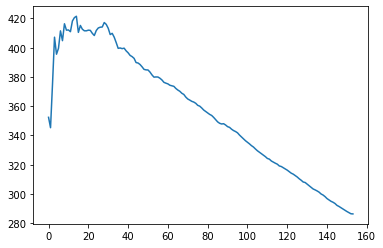


Loss = 71.01326518877188:  34%|███▍      | 52/154 [05:22<10:30,  6.18s/it]


Loss = 69.03064832078151:  68%|██████▊   | 104/154 [11:22<06:04,  7.29s/it]


Loss = 39.77567729526458: 100%|██████████| 154/154 [17:15<00:00,  6.72s/it]


Test loss = 62.405187880311594


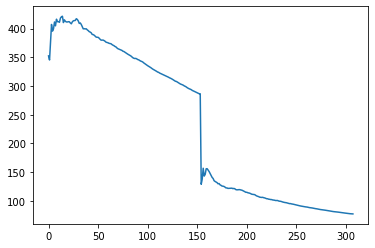


Loss = 52.433961666529285:  34%|███▍      | 52/154 [06:13<12:31,  7.37s/it]


Loss = 38.93440786934647:  68%|██████▊   | 104/154 [11:53<05:16,  6.33s/it]


Loss = 26.083449788631295: 100%|██████████| 154/154 [17:10<00:00,  6.69s/it]


Test loss = 28.680258632229666


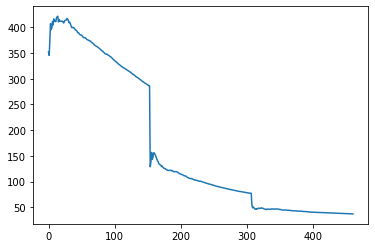


Loss = 24.9187916787958:  33%|███▎      | 51/154 [05:25<10:43,  6.24s/it]  


Loss = 27.383353251114258:  67%|██████▋   | 103/154 [11:47<06:24,  7.53s/it]


Loss = 18.0530826316128: 100%|██████████| 154/154 [18:08<00:00,  7.07s/it]


Test loss = 18.372934654792765


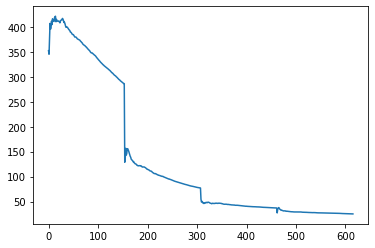


Loss = 14.268025331989246:  33%|███▎      | 51/154 [05:59<10:42,  6.24s/it]


Loss = 15.734579437256428:  67%|██████▋   | 103/154 [11:19<05:17,  6.23s/it]


Loss = 6.733373566268338: 100%|██████████| 154/154 [16:32<00:00,  6.45s/it]


Test loss = 8.592869884825776


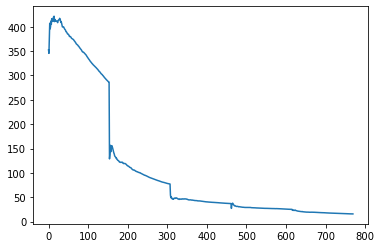


Loss = 9.070874019726908:  34%|███▍      | 52/154 [05:59<12:09,  7.15s/it]


Loss = 7.075726144557846:  68%|██████▊   | 104/154 [12:14<06:06,  7.33s/it]


Loss = 4.29185474270215: 100%|██████████| 154/154 [18:07<00:00,  7.06s/it]


Test loss = 4.502130026483145


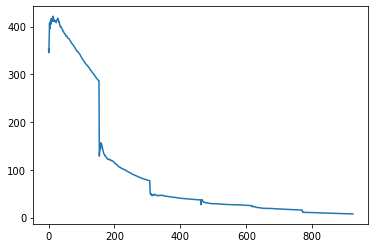


Loss = 4.039785267296159:  34%|███▍      | 52/154 [04:42<08:02,  4.73s/it]


Loss = 2.8092736879544065:  68%|██████▊   | 104/154 [08:42<03:58,  4.78s/it]


Loss = 2.521568854908628: 100%|██████████| 154/154 [12:32<00:00,  4.89s/it]


Test loss = 2.528538714846416


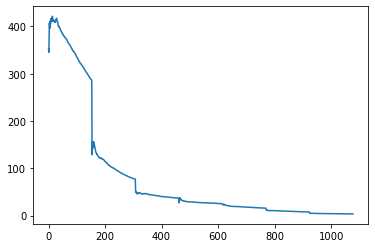


Loss = 2.8990344903337744:  33%|███▎      | 51/154 [04:00<07:59,  4.66s/it]


Loss = 2.9450427712157925:  67%|██████▋   | 103/154 [08:03<04:03,  4.77s/it]


Loss = 3.006407296696537: 100%|██████████| 154/154 [11:56<00:00,  4.65s/it]


Test loss = 3.005196550423316


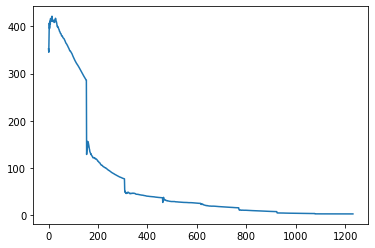


Loss = 2.861868509190873:  33%|███▎      | 51/154 [03:59<07:47,  4.54s/it] 


Loss = 2.7130617680439983:  67%|██████▋   | 103/154 [08:03<04:03,  4.77s/it]


Loss = 2.510192477325961: 100%|██████████| 154/154 [12:34<00:00,  4.90s/it]


Test loss = 2.5101154506686196


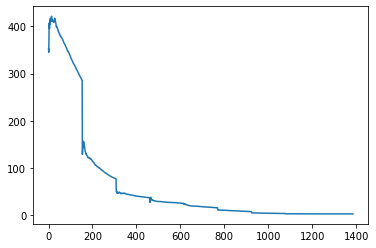


Loss = 2.9018727128151016:  33%|███▎      | 51/154 [05:55<11:53,  6.93s/it]


Loss = 2.75427823905777:  67%|██████▋   | 103/154 [11:56<05:54,  6.95s/it] 


Loss = 2.9797647072639286: 100%|██████████| 154/154 [17:41<00:00,  6.89s/it]


Test loss = 2.9793819964338546


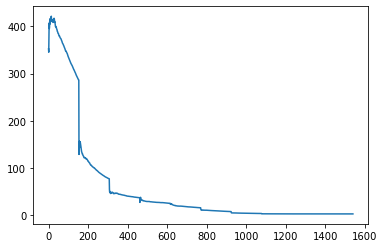


Loss = 2.797597178947418:  34%|███▍      | 52/154 [05:58<11:34,  6.80s/it]


Loss = 2.880378648447719:  55%|█████▍    | 84/154 [09:48<08:10,  7.00s/it] 


KeyboardInterrupt: 

In [75]:
## size of a mini-batch
## learning rate
lr=1e-5 #@param {'type':'number'}
batch_size = 128#@param {'type':'integer'}
## learning rate
dataloader = DataLoader(my_dataset,batch_size=batch_size, shuffle=True, generator=torch.Generator(device=dev))
testloader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False, generator=torch.Generator(device=dev))
n_epochs = 50
tqdm_epoch = tqdm.notebook.trange(n_epochs)
optimizer = Adam(score_model.parameters(), lr=lr)
i = 0
epoch_losses =[]
for epoch in tqdm_epoch:
    t_dl =tqdm.tqdm(dataloader)
    avg_loss = 0.
    num_items = 0
    for pw in t_dl:
        x = pw[0].to(dev)
        i += 1
        score_model.requires_grad_()
        loss = loss2(score_model, x,eps=torch.tensor([1e-11]), lam =100)
        t_dl.set_description(f"Loss = {loss.item()}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        epoch_losses.append(avg_loss / num_items)
        #torch.save(score_model.state_dict(), f"ckpt_moser_sphere{epoch}.pth")
    tesla =0
    for td in testloader:
        loss = loss2(score_model, x,eps=torch.tensor([1e-11]), lam =100).item()
        tesla += loss/len(testloader)
    print(f"Test loss = {tesla}")
    torch.save(score_model.state_dict(), f"ckpt_moser_sphere{epoch}.pth")
    plt.plot(epoch_losses)
    plt.show()
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), f"ckpt_moser_sphere{epoch}.pth")

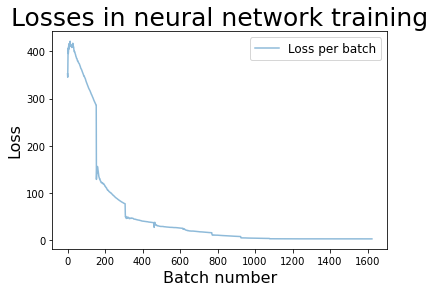

In [76]:
#xs = np.arange(0,len(epoch_losses),len(epoch_losses)//len(test_losses))
#plt.plot(xs[1:],test_losses, color = 'blue', label = 'Test data loss')
plt.plot(epoch_losses, alpha = 0.5, label = 'Loss per batch')
plt.xlabel('Batch number', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Losses in neural network training', fontsize = 25)
plt.legend(fontsize = 12)
plt.savefig('training_sphere_moser.pdf')

In [77]:
import matplotlib.pyplot as plt

In [78]:
score_model.eval()

ScoreNet(
  (lin1): Linear(in_features=3, out_features=75, bias=True)
  (lin2): Linear(in_features=75, out_features=75, bias=True)
  (lin3): Linear(in_features=75, out_features=75, bias=True)
  (lin4): Linear(in_features=75, out_features=3, bias=True)
  (act): Tanh()
)

In [79]:
### now finding the density
def density(x,L):
    divergence = torch.trace(torch.squeeze(torch.autograd.functional.jacobian(score_model, inputs=(x,L), create_graph=True,vectorize=True)[0]))
    return (1/(4*torch.pi) - divergence)

In [ ]:
for i in range(100):
    theta= torch.rand(1)*torch.pi*2
    phi = torch.acos(2*torch.rand(1) -1)
    x = torch.tensor([torch.sin(theta)*torch.cos(phi),torch.sin(theta)*torch.sin(phi),torch.cos(theta)])
    x.requires_grad_()
    gs = [lambda x: x[0]**2 + x[1]**2 + x[2]**2-1]
    L_fn = cotangent_projection(gs)

    def find_score(x):
        L = L_fn(x)
        score = score_model(x,L).to(dev)
        return score
    sim_x = torch.unsqueeze(x,0)
    sim_x.requires_grad_()
    L = L_fn(sim_x)
    torch.autograd.functional.jacobian(find_score, inputs=(sim_x))
    print(density(sim_x,L))

In [82]:
def get_result(x):
    gs = [lambda x: x[0]**2 + x[1]**2 + x[2]**2-1]
    L_fn = cotangent_projection(gs)
    L = L_fn(x)
    return score_model(x,L)

In [86]:
def get_density(x):
    div = torch.trace(torch.squeeze(torch.autograd.functional.jacobian(get_result, inputs=(x), create_graph=False,vectorize=True)))
    return 1/(4*torch.pi) - div

In [87]:
from matplotlib import cm, colors
from matplotlib.colors import Normalize

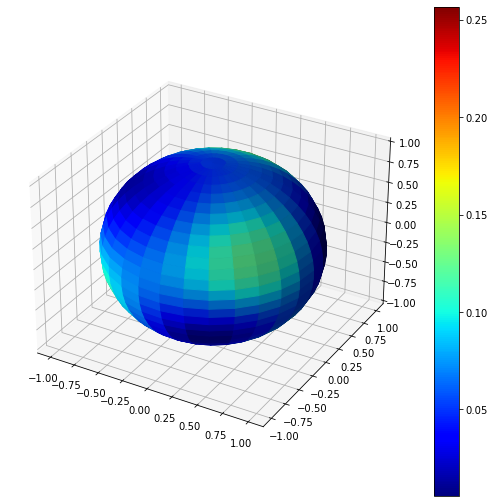

In [89]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm


phi = np.linspace(0, np.pi, 30)
theta = np.linspace(0, 2*np.pi, 30)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)


m, l = 2, 3


# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
#fcolor = pi_1(x,y)



# Set the aspect ratio to 1 so our sphere looks spherical

colormap = plt.cm.viridis

scalar_values = np.zeros_like(x)
for i in range(len(x)):
    for j in range(len(x)):
        scalar_values[i][j] = get_density(torch.tensor([x[i][j], y[i][j], z[i][j]], device =dev)).detach().cpu().numpy()
        
norm = Normalize(scalar_values.min(), scalar_values.max())


# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.jet(norm(scalar_values)))
ax.set_xticks([-1,-.75,-.5,-.25,0,.25,.5,.75,1])
ax.set_zticks([-1,-.75,-.5,-.25,0,.25,.5,.75,1])

m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
m.set_array([])
plt.colorbar(m)

# Turn off the axis planes
#ax.set_axis_off()
plt.savefig("moser_globe.pdf")

In [ ]:
def get_theta(theta,phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)* np.sin(phi)
    z = np.cos(theta)
    t = torch.tensor([x,y,z])
    return get_density(t)*theta**2 *np.sin(theta)

In [ ]:
def get_phi(theta,phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)* np.sin(phi)
    z = np.cos(theta)
    t = torch.tensor([x,y,z])
    return get_density(t)*phi**2 *np.sin(theta)

In [ ]:
from scipy.integrate import dblquad

In [ ]:
dblquad(get_theta, 0, 2*np.pi, 0, np.pi)

In [ ]:
dblquad(get_phi, 0, 2*np.pi, 0, np.pi)

In [ ]:
plt.plot(epoch_losses)

In [ ]:
## size of a mini-batch
## learning rate
lr=1e-6 #@param {'type':'number'}
batch_size =  16 #@param {'type':'integer'}
## learning rate
dataloader = DataLoader(my_dataset,batch_size=batch_size, shuffle=True)
n_epochs = 20
tqdm_epoch = tqdm.notebook.trange(n_epochs)
optimizer = Adam(score_model.parameters(), lr=lr)
i = 0
for epoch in tqdm_epoch:
    t_dl =tqdm.tqdm(dataloader)
    avg_loss = 0.
    num_items = 0
    for pw in t_dl:
        x = pw[0].to(dev)
        i += 1
        loss = loss2(score_model, x)
        t_dl.set_description(f"Loss = {loss.item()}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        epoch_losses.append(avg_loss / num_items)
        gradient = torch.gradcheck(score_model, x)
        print(f"Gradient = {gradient}")
        break
    plt.plot(epoch_losses)
    plt.show()
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), 'ckpt_improved.pth')

In [ ]:
score_model.eval()

In [ ]:
x = torch.rand(57)
x.requires_grad_()

In [ ]:
def phi_dens(theta,phi):
    x = 

# generating a uniform position

In [ ]:
data = np.load('positions_gamma_5.npy',allow_pickle=True)[-100000:]

In [ ]:
q=data_tensor[0]

In [ ]:
score_model.eval()

In [ ]:
### now finding the density
def density(x,L):
    divergence = torch.trace(torch.squeeze(torch.autograd.functional.jacobian(score_model, inputs=(x,L), create_graph=True,strict=True)))
    return 1/(4*torch.pi)**(18) - divergence

In [ ]:
for i in range(1000):
    random_pose = torch.flatten(uniform_generator(q,bones))
    q = torch.squeeze(random_pose) # x is unsqueezed I can't remember why
    gs = [length_constraint(i,j,torch.squeeze(q)) for (i,j) in bones2]
    gs.append(length_constraint_2(1,torch.squeeze(q)))
    gs.append(length_constraint_2(11,torch.squeeze(q)))
    gs.append(length_constraint_2(15,torch.squeeze(q)))
    L_fn = cotangent_projection(gs)
    sim_x = torch.unsqueeze(random_pose,0)
    L = L_fn(sim_x)
    print(density(sim_x,L))

since the original SDE was just Brownian motion, the reverse is simply:

In [ ]:
data = np.load('train_dataset.npy')
x_init = torch.squeeze(torch.tensor(data[0]))